# CSIRO - Image2Biomass Prediction: Advanced Computer Vision Pipeline

## Project Overview
This notebook presents a state-of-the-art solution for estimating pasture biomass from satellite/aerial imagery using modern deep learning techniques. 
Accurately predicting biomass (Green, Dead, and Clover components) is crucial for sustainable agriculture and efficient grazing management.

### Key Techniques Used:
*   **Foundation Model:** Utilization of **DINOv3 (ViT-Huge)**, a self-supervised Vision Transformer, as a powerful feature extractor.
*   **LoRA (Low-Rank Adaptation):** Efficient fine-tuning of the huge backbone with minimal GPU memory usage (~0.5% trainable parameters).
*   **Dual-View Architecture:** Processing left and right image crops simultaneously with feature fusion.
*   **Gradient Accumulation:** Enabling effective batch training on limited GPU hardware (P100).
*   **Post-Processing Optimization:** Automated scaling factor search to correct systematic model bias.

---

## 1. Imports & Setup
We start by importing essential libraries for deep learning (PyTorch), image processing (PIL, torchvision), and data handling (Pandas). 
We also install `peft` for LoRA integration.

In [1]:
#!pip install -q peft

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import timm
from peft import get_peft_model, LoraConfig, TaskType
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm

# Set seed for reproducibility
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(77)

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## 2. Configuration
All hyperparameters are centralized in the `CFG` class for easy tuning. 
We use **Gradient Accumulation (16 steps)** to simulate a larger batch size of 16 despite using `BATCH_SIZE = 1` to save VRAM.

In [2]:
class CFG:
    # Paths
    base_path: Path = Path("../input/csiro-biomass/")
    SAVE_DIR = Path("/kaggle/working")
    MODEL_FILENAME = "best_dinov3_biomass_lora.pth"
    
    # Target Columns (We predict components, not totals)
    TARGET_COLS: list = [
        'Dry_Green_g',
        'Dry_Dead_g',
        'Dry_Clover_g'
    ]
    
    # Hyperparameters
    MODEL_NAME = "vit_huge_plus_patch16_dinov3.lvd1689m"
    IMG_SIZE = 512
    BATCH_SIZE = 1          # Optimized for 16GB VRAM
    ACCUMULATION_STEPS = 16 # Effective Batch Size = 16
    EPOCHS = 70             # LoRA converges relatively fast
    LR = 3e-4               # Higher LR for LoRA training
    WD = 1e-4               # Weight Decay
    PATIENCE = 5            # Early Stopping

    SEED = 77

cfg = CFG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


## 3. Data Preprocessing
We load the metadata and prepare the training DataFrame.
To ensure robust evaluation, we use **StratifiedGroupKFold**. This prevents data leakage by keeping all images from the same day (`Sampling_Date`) in the same fold.

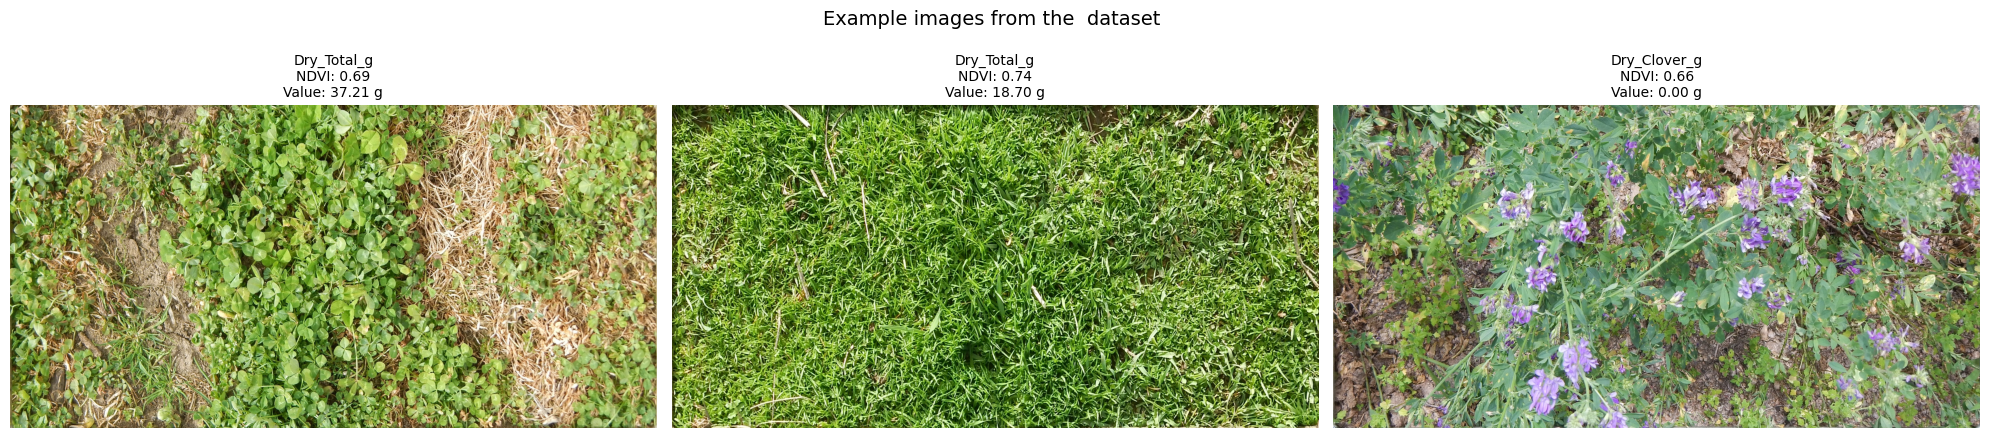

In [3]:
train_data = pd.read_csv(cfg.base_path / "train.csv")
sample_df = train_data.sample(3)

plt.figure(figsize=(20,5))

for i, row in enumerate(sample_df.itertuples()):
    # Bild laden
    img = mpimg.imread(cfg.base_path / row.image_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    
    # Titel: Zeige Target-Name + NDVI + Zielwert
    plt.title(
        f"{row.target_name}\nNDVI: {row.Pre_GSHH_NDVI:.2f}\nValue: {row.target:.2f} g",
        fontsize=10
    )

plt.suptitle("Example images from the  dataset ", fontsize=14)
plt.tight_layout()
plt.show()

In [4]:
# Load CSVs
train_data = pd.read_csv(cfg.base_path / "train.csv")
test_data = pd.read_csv(cfg.base_path / "test.csv")

# Pivot to get one row per image with multiple targets
train_df = (
    train_data.pivot_table(
        index=["image_path", "Sampling_Date", "State", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"],
        columns="target_name",
        values="target",
        aggfunc="first"
    ).reset_index()
)

# --- Stratified Group K-Fold Split ---
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=cfg.SEED)

train_df['fold'] = -1
groups = train_df['Sampling_Date']
y_stratify = train_df['State'] 

for fold_id, (train_idx, val_idx) in enumerate(sgkf.split(train_df, y=y_stratify, groups=groups)):
    train_df.loc[val_idx, 'fold'] = fold_id

# Select Fold 0 for Validation
val_df = train_df[train_df['fold'] == 0].reset_index(drop=True)
train_df = train_df[train_df['fold'] != 0].reset_index(drop=True)

print(f"Train Samples: {len(train_df)} | Validation Samples: {len(val_df)}")
print("Leakage Check (Overlapping Dates):", set(train_df.Sampling_Date) & set(val_df.Sampling_Date))

Train Samples: 267 | Validation Samples: 90
Leakage Check (Overlapping Dates): set()


## 4. Dataset & Augmentation
The dataset class handles loading images and splitting them into **Left** and **Right** crops (as per competition structure).
We apply **Heavy Augmentation** (ColorJitter, Flips, Rotation) to the training set to improve generalization against varying lighting conditions.

In [5]:
class PastureImageDataset(Dataset):
    def __init__(self, df, image_root: Path, target_cols=None, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.image_root = image_root
        self.target_cols = target_cols
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.image_root / row["image_path"]
        img = Image.open(img_path).convert("RGB")

        w, h = img.size
        # Crop Left / Right parts of the panoramic image
        left_img  = img.crop((0, 0, h, h))
        right_img = img.crop((w - h, 0, w, h))

        if self.transform:
            left_img  = self.transform(left_img)
            right_img = self.transform(right_img)

        if self.is_test:
            return (left_img, right_img)
        
        targets = torch.tensor(row[self.target_cols].astype(np.float32).values)
        return (left_img, right_img), targets

# --- Augmentations ---
train_tfms = T.Compose([
    T.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1), # Robustness to light
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tfms = T.Compose([
    T.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Datasets & Loaders
train_ds = PastureImageDataset(train_df, cfg.base_path, cfg.TARGET_COLS, transform=train_tfms)
val_ds = PastureImageDataset(val_df, cfg.base_path, cfg.TARGET_COLS, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, pin_memory=True)

## 5. Model Architecture (DINOv3 + LoRA)
We leverage the **DINOv3 Huge** backbone. Instead of full fine-tuning (which requires ~48GB VRAM), we inject **LoRA (Low-Rank Adaptation)** layers. 
This allows us to train the model on a standard GPU by updating only **~0.8% of the parameters**.

The architecture processes both image crops (Left/Right) independently and fuses their features before regression.

In [6]:
class LoRABiomassModel(nn.Module):
    def __init__(self, backbone_name, pretrained=True):
        super().__init__()
        
        # 1. Load Backbone
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool='', 
        )
        
        # 2. Inject LoRA Adapters
        peft_config = LoraConfig(
            r=16,             # Rank 16 provides a good balance of capacity and efficiency
            lora_alpha=32,    # Scaling factor
            target_modules=["qkv", "proj", "fc1", "fc2"], # Target all attention & MLP blocks
            lora_dropout=0.05,
            bias="none",
            inference_mode=False 
        )
        self.backbone = get_peft_model(self.backbone, peft_config)
        self.backbone.print_trainable_parameters()
        
        # Get embedding dimension
        if hasattr(self.backbone, "base_model"):
            nf = self.backbone.base_model.model.num_features
        else:
            nf = self.backbone.num_features

        # 3. Fusion & Regression Heads
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # Fuses features from Left and Right images
        self.fusion = nn.Sequential(
            nn.Linear(nf * 2, nf),
            nn.LayerNorm(nf),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        
        # Multi-Head Output (Green, Dead, Clover)
        self.head_green = nn.Linear(nf, 1)
        self.head_dead = nn.Linear(nf, 1)
        self.head_clover = nn.Linear(nf, 1)

    def forward(self, x):
        left, right = x
        
        # Extract Features (LoRA active)
        x_l = self.backbone(left)
        x_r = self.backbone(right)
        
        # Global Average Pooling over patches
        x_l = x_l.mean(dim=1) 
        x_r = x_r.mean(dim=1)
        
        # Concatenate & Fuse
        x_cat = torch.cat([x_l, x_r], dim=1)
        feat = self.fusion(x_cat)
        
        # Predictions (Softplus ensures positive mass)
        green = nn.functional.softplus(self.head_green(feat))
        dead = nn.functional.softplus(self.head_dead(feat))
        clover = nn.functional.softplus(self.head_clover(feat))
        
        return torch.cat([green, dead, clover], dim=1)

# Initialize
model = LoRABiomassModel(backbone_name=cfg.MODEL_NAME).to(device)

model.safetensors:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

trainable params: 7,241,728 || all params: 847,751,168 || trainable%: 0.8542


## 6. Training Pipeline
We implement a robust training loop featuring:
*   **Gradient Accumulation:** To stabilize training with small batch sizes.
*   **Mixed Precision (AMP):** To reduce memory usage and speed up training.
*   **L1 Loss (MAE):** Robust to outliers in biomass data.
*   **Scheduler:** `ReduceLROnPlateau` to fine-tune learning rates dynamically.

In [7]:
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WD)
scaler = torch.amp.GradScaler('cuda')

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3 
)

def train_one_epoch(loader):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    pbar = tqdm(loader, desc="Train")
    for step, ((img_l, img_r), targets) in enumerate(pbar):
        img_l, img_r = img_l.to(device), img_r.to(device)
        targets = targets.to(device)
        
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            preds = model((img_l, img_r))
            loss = criterion(preds, targets)
            loss = loss / cfg.ACCUMULATION_STEPS # Scale loss
        
        scaler.scale(loss).backward()
        
        if (step + 1) % cfg.ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        current_loss = loss.item() * cfg.ACCUMULATION_STEPS
        total_loss += current_loss
        pbar.set_postfix(loss=current_loss)
        
    return total_loss / len(loader)

@torch.no_grad()
def valid_one_epoch(loader):
    model.eval()
    total_loss = 0
    preds_list = []
    targets_list = []
    
    for (img_l, img_r), targets in tqdm(loader, desc="Valid"):
        img_l, img_r = img_l.to(device), img_r.to(device)
        targets = targets.to(device)
        
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            preds = model((img_l, img_r))
            loss = criterion(preds, targets)
        
        total_loss += loss.item()
        preds_list.append(preds.cpu().numpy())
        targets_list.append(targets.cpu().numpy())
            
    return total_loss / len(loader), np.concatenate(preds_list), np.concatenate(targets_list)

## 7. Execution
We train the model with Early Stopping to prevent overfitting.

In [8]:
best_val_loss = float('inf')
patience_counter = 0
save_path = cfg.SAVE_DIR / cfg.MODEL_FILENAME

print(f"\n Starting Training (Batch Size {cfg.BATCH_SIZE} | Accumulation {cfg.ACCUMULATION_STEPS})...")

for epoch in range(cfg.EPOCHS):
    curr_lr = optimizer.param_groups[0]['lr']
    print(f"\n--- Epoch {epoch + 1}/{cfg.EPOCHS} | LR: {curr_lr:.2e} ---")
    
    train_loss = train_one_epoch(train_loader)
    val_loss, val_preds, val_targets = valid_one_epoch(val_loader)
    
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"New Best Model Saved: {save_path}")
        
        mae_cols = np.mean(np.abs(val_targets - val_preds), axis=0)
        print(f"    Details (MAE): Green={mae_cols[0]:.1f}, Dead={mae_cols[1]:.1f}, Clover={mae_cols[2]:.1f}")
    else:
        patience_counter += 1
        print(f"!!! No Improvement. Patience: {patience_counter}/{cfg.PATIENCE}")
        if patience_counter >= cfg.PATIENCE:
            print("\n Early Stopping Triggered.")
            break


 Starting Training (Batch Size 1 | Accumulation 16)...

--- Epoch 1/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 11.8138 | Val Loss: 10.4327
New Best Model Saved: /kaggle/working/best_dinov3_biomass_lora.pth
    Details (MAE): Green=17.0, Dead=11.1, Clover=3.2

--- Epoch 2/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 9.9567 | Val Loss: 9.7073
New Best Model Saved: /kaggle/working/best_dinov3_biomass_lora.pth
    Details (MAE): Green=15.8, Dead=10.2, Clover=3.1

--- Epoch 3/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 9.2004 | Val Loss: 9.4038
New Best Model Saved: /kaggle/working/best_dinov3_biomass_lora.pth
    Details (MAE): Green=15.5, Dead=9.6, Clover=3.1

--- Epoch 4/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 8.5181 | Val Loss: 8.9593
New Best Model Saved: /kaggle/working/best_dinov3_biomass_lora.pth
    Details (MAE): Green=14.9, Dead=9.0, Clover=3.0

--- Epoch 5/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 8.0557 | Val Loss: 8.7701
New Best Model Saved: /kaggle/working/best_dinov3_biomass_lora.pth
    Details (MAE): Green=14.1, Dead=9.1, Clover=3.1

--- Epoch 6/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 7.5105 | Val Loss: 8.4580
New Best Model Saved: /kaggle/working/best_dinov3_biomass_lora.pth
    Details (MAE): Green=13.9, Dead=8.6, Clover=2.9

--- Epoch 7/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 7.1114 | Val Loss: 8.7375
!!! No Improvement. Patience: 1/5

--- Epoch 8/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 6.7970 | Val Loss: 8.2733
New Best Model Saved: /kaggle/working/best_dinov3_biomass_lora.pth
    Details (MAE): Green=12.6, Dead=9.2, Clover=3.0

--- Epoch 9/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 6.4477 | Val Loss: 8.0651
New Best Model Saved: /kaggle/working/best_dinov3_biomass_lora.pth
    Details (MAE): Green=12.5, Dead=8.1, Clover=3.7

--- Epoch 10/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 6.2931 | Val Loss: 7.8944
New Best Model Saved: /kaggle/working/best_dinov3_biomass_lora.pth
    Details (MAE): Green=13.0, Dead=7.7, Clover=2.9

--- Epoch 11/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 5.9212 | Val Loss: 7.1573
New Best Model Saved: /kaggle/working/best_dinov3_biomass_lora.pth
    Details (MAE): Green=11.9, Dead=7.1, Clover=2.4

--- Epoch 12/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 5.7346 | Val Loss: 7.6649
!!! No Improvement. Patience: 1/5

--- Epoch 13/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 5.2605 | Val Loss: 7.1872
!!! No Improvement. Patience: 2/5

--- Epoch 14/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 5.0997 | Val Loss: 7.1728
!!! No Improvement. Patience: 3/5

--- Epoch 15/70 | LR: 3.00e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 4.8323 | Val Loss: 7.3411
!!! No Improvement. Patience: 4/5

--- Epoch 16/70 | LR: 1.50e-04 ---


Train:   0%|          | 0/267 [00:00<?, ?it/s]

Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 4.7059 | Val Loss: 7.1652
!!! No Improvement. Patience: 5/5

 Early Stopping Triggered.


## 8. Post-Processing Optimization
After training, we analyze the validation predictions to find optimal scaling factors. 
Models often systematically under- or overestimate certain biomass types (e.g., Clover). We correct this by applying a multiplier.

In [9]:
print("\n--- Optimizing Post-Processing Factors ---")

# Clear GPU memory
del model
torch.cuda.empty_cache()

# Reload best model
model = LoRABiomassModel(backbone_name=cfg.MODEL_NAME).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

_, preds, targets = valid_one_epoch(val_loader)
preds[preds < 0] = 0

cols = ["Green", "Dead", "Clover"]
best_factors = [1.0, 1.0, 1.0]

for i in range(3):
    best_mae = float('inf')
    best_f = 1.0
    # Brute-force search for best multiplier
    for f in np.linspace(0.8, 4.0, 321): 
        temp_preds = preds[:, i] * f
        mae = np.mean(np.abs(targets[:, i] - temp_preds))
        if mae < best_mae:
            best_mae = mae
            best_f = f
    best_factors[i] = best_f
    print(f"Best Factor for {cols[i]}: {best_f:.2f}")

print("-" * 30)
print("FINAL FACTORS FOR SUBMISSION:")
print(f"preds[:, 0] *= {best_factors[0]:.2f} (Green)")
print(f"preds[:, 1] *= {best_factors[1]:.2f} (Dead)")
print(f"preds[:, 2] *= {best_factors[2]:.2f} (Clover)")


--- Optimizing Post-Processing Factors ---
trainable params: 7,241,728 || all params: 847,751,168 || trainable%: 0.8542


Valid:   0%|          | 0/90 [00:00<?, ?it/s]

Best Factor for Green: 1.12
Best Factor for Dead: 1.27
Best Factor for Clover: 0.85
------------------------------
FINAL FACTORS FOR SUBMISSION:
preds[:, 0] *= 1.12 (Green)
preds[:, 1] *= 1.27 (Dead)
preds[:, 2] *= 0.85 (Clover)
